# Importations

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import ImageGrab
import time

In [2]:
import torch
torch.cuda.is_available()

True

A supprimer

In [33]:
# Permet de récuperer des images en réalisant des captures d'écran
# Cette fonction sera supprimé par la suite, mais permet de tester le modèle temporairement 

def test_recuperation_image() :
    i = 0
    screenshots = []
    while (i<200) :
        screenshot = ImageGrab.grab().convert('L')
        screenshots.append(screenshot)
        i += 1
    return screenshots

(1080, 1920)


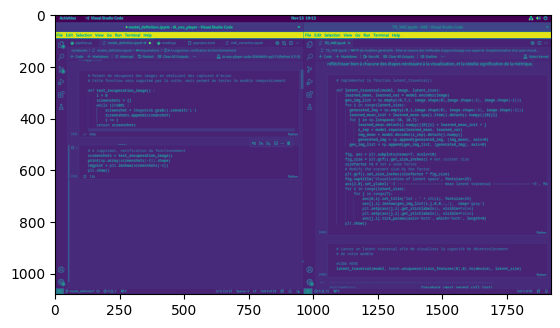

In [34]:
# A supprimer, verification du fonctionnement
screenshots = test_recuperation_image()
print(np.array(screenshots[-1]).shape)
imgplot = plt.imshow(screenshots[-1])
plt.show()

Tout écrire en pytorch

# Application de conv2d (CNN) sur les images

In [6]:
# Permet de transfomer une matrice (d'une image) en une matrice d'une colone
# Pour l'application d'un réseau de neurone par la suite

def flatten_image(contours_image):
    # Aplatir l'image en une seule colonne
    flattened_image = contours_image.flatten()

    # Renvoyer la matrice aplatie
    return flattened_image

In [7]:
import torch.nn.functional as F
from PIL import Image

# Permet de réaliser la detection de contour d'une seule image

def contour_detection_one_image(image) :

    # Convertir en niveaux de gris
    image_gray = image.convert("L")

    # Convertir en un tableau NumPy
    image_array = np.array(image_gray)

    # Convertir en un tenseur PyTorch
    image_tensor = torch.unsqueeze(torch.unsqueeze(torch.tensor(image_array, dtype=torch.float32), 0), 0)

    # Définir un filtre pour la détection de contours (Sobel filter)
    sobel_filter_x = torch.tensor([[1, 0, -1],
                                    [2, 0, -2],
                                    [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3)

    sobel_filter_y = torch.tensor([[1, 2, 1],
                                    [0, 0, 0],
                                    [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3)

    # Appliquer conv2d pour détecter les contours en utilisant les filtres Sobel
    contours_x = F.conv2d(image_tensor, sobel_filter_x, padding=1)  # Ajout de padding pour garder la même taille
    contours_y = F.conv2d(image_tensor, sobel_filter_y, padding=1)

    # Calculer le gradient du contour
    gradient_magnitude = torch.sqrt(contours_x ** 2 + contours_y ** 2)

    # Seuiller l'image pour obtenir des contours binaires
    seuil = 0.5  # Vous pouvez ajuster ce seuil en fonction de votre capture d'écran
    contours_binaires = (gradient_magnitude > seuil).float()

    contours_image = contours_binaires.squeeze().numpy()

    flattened_image = flatten_image(contours_image)

    return image_array, contours_image, flattened_image


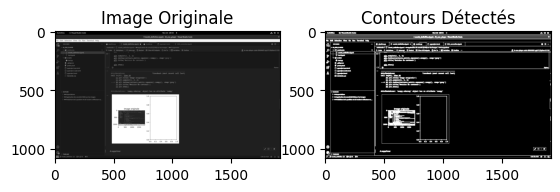

Image flatten:
[0. 0. 0. ... 1. 1. 1.]
Dimensions de l'image flatten: (2073600,)


In [8]:
# A supprimer, test de la fonction contour_detection_one_image

# Appel de la fonction de capture d'écran, et récupération de ces captures
screenshots = test_recuperation_image()

# Récupérer la dernière capture d'écran
image_test = screenshots[-1]

image_final_test, contours_image_test, flattened_image = contour_detection_one_image(image_test)

# Afficher l'image originale et les contours détectés
plt.subplot(1, 2, 1)
plt.imshow(image_final_test, cmap='gray')
plt.title('Image Originale')

plt.subplot(1, 2, 2)
plt.imshow(contours_image_test, cmap='gray')
plt.title('Contours Détectés')
plt.show()


# Afficher l'image flatten
print("Image flatten:")
print(flattened_image)

# Afficher les dimensions de l'image flatten
print("Dimensions de l'image flatten:", flattened_image.shape)

ContourDetector(
  (Conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Conv2): Conv2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Pool): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Flat): Flatten(start_dim=1, end_dim=-1)
)
torch.Size([1, 1080, 1920])
torch.Size([32, 270, 480])
torch.Size([1, 68, 120])


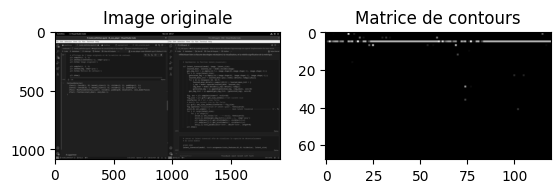

In [40]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

class ContourDetector(nn.Module):
    def __init__(self):

        super(ContourDetector, self).__init__()

        # Couches de convolution
        self.Conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.Conv2 = nn.Conv2d(32, 1, kernel_size=3, stride=2, padding=1)
        # Couches de pooling
        self.Pool = nn.MaxPool2d(kernel_size=1, stride=2, padding=0)
        self.Flat=nn.Flatten()


    def forward(self, x):
        # Passe avant les couches de convolution
        print(x.shape)
        x = self.Pool(F.relu(self.Conv1(x)))

        print(x.shape)
        z = self.Pool(F.relu(self.Conv2(x)))
        print(z.shape)


        return z

# Initialiser le modèle
contour_model = ContourDetector()
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5, ], [0.5, ])])
# Afficher le modèle
print(contour_model)


screenshots = test_recuperation_image()
image = screenshots[-1]
image = transform(image)

# # Test de la fonction
contours_matrix = contour_model(image)
img = contours_matrix.detach().numpy()[0]

# Affichage de l'image originale et de la matrice de contours
plt.subplot(1, 2, 1)
plt.imshow(screenshots[-1], cmap='gray')
plt.title('Image originale')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.title('Matrice de contours')

plt.show()

A supprimer

In [12]:
# Permet de réaliser une détection de contour sur un tableau d'image 
# Je pense sera à supprimer

def contour_detection_table_image(images) :

    # Initialisation pour enregistrer les images qui ont été traitées, et les images des contours 
    images_final = []
    contours_images = []

    # Application de la méthode de détection de contour à toutes mes images
    for image in images : 
        image_final, contours_image = contour_detection_one_image(image)

        # Enregistrement de l'image traitée et de a détection de contour dans les tableaux
        images_final.append(image_final)
        contours_images.append(contours_image)

    return images_final, contours_images

In [26]:
# A supprimer, teste de la méthode contour_detection_table_image

screenshots = test_recuperation_image()
images_final, contours_images = contour_detection_table_image(screenshots)

# Afficher l'image originale et les contours détectés
plt.subplot(1, 2, 1)
plt.imshow(images_final[100], cmap='gray')
plt.title('Image Originale')

plt.subplot(1, 2, 2)
plt.imshow(contours_images[100], cmap='gray')
plt.title('Contours Détectés')
plt.show()

# Afficher l'image originale et les contours détectés
plt.subplot(1, 2, 1)
plt.imshow(images_final[-1], cmap='gray')
plt.title('Image Originale')

plt.subplot(1, 2, 2)
plt.imshow(contours_images[-1], cmap='gray')
plt.title('Contours Détectés')
plt.show()

# Prédiciton de la position et de l'action à effectuer sur la prochaine image

Classe LSTM (Long Short Term Memory) 

In [36]:
import torch.nn as nn

class MouseActionLSTM(nn.Module):
    """
    Classe définissant un modèle LSTM pour la prédiction des actions de la souris.
    
    Elle utilise une couche LSTM suivie d'une couche totalement connectée.
    Elle prend en compte une entrée composée d'une image aplatie (flatten) et de 6 valeurs supplémentaires : 
        - position x de la souris
        - position y de la souris
        - 0 (1 si la souris clique, mais a fini son action à ce moment)
        - 1 si on est en train de maintenir le clique, 0 sinon
        - 0 (1 si on fini de cliquer, mais a fini son action)
        - 1 si on fait rien, 0 sinon 

    Paramètres :
    - input_size : Taille de l'entrée du modèle.
    - hidden_size : Taille de la couche cachée LSTM.
    - output_size : Taille de la sortie du modèle.

    Méthodes :
    - forward : Définit le passage avant du modèle.
    """

    def __init__(self, input_size, hidden_size, output_size):
        # Appeler le constructeur de la classe parente
        super(MouseActionLSTM, self).__init__()

        # Couche LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Couche dnese totalement connectée
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x est l'entrée du modèle

        # Passage à travers la couche LSTM
        lstm_out, _ = self.lstm(x)

        # Ne prendre que la sortie du dernier pas de temps
        lstm_out = lstm_out[:, -1, :]

        # Passage à travers la couche totalement connectée
        output = self.fc(lstm_out)

        # Renvoyer la sortie du modèle
        return output

Instanciation du modèle

In [37]:
input_size = 2073600 + 6  # Taille de l'entrée : flattened_image + les 6 informations de la souris
hidden_size = 64  # Taille de la couche cachée LSTM
output_size = 6  # Taille de la sortie : 6 pour les actions possibles

# Instanciation du modèle
model = MouseActionLSTM(input_size, hidden_size, output_size)

Définition de la fonction de perte et l'optimiseur (à checker)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Entrainement du modèle (à checker)

In [38]:
# Entraîner le modèle avec vos données d'entraînement
# Les données d'entraînement doivent être dans train_data et train_labels

num_epochs = 10
for epoch in range(num_epochs):
    # Convertir les données en tenseurs PyTorch
    inputs = torch.tensor(train_data, dtype=torch.float32)
    labels = torch.tensor(train_labels, dtype=torch.long)

    # Réinitialiser les gradients
    optimizer.zero_grad()

    # Passage avant
    outputs = model(inputs)

    # Calculer la perte
    loss = criterion(outputs, labels)

    # Passage arrière et optimisation
    loss.backward()
    optimizer.step()

    # Afficher la perte à chaque époque
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

NameError: name 'train_data' is not defined